# Passive liquidity on order books

How to run this notebook:

```shell
# Create virtual environment
python3 -m venv ~/.virtualenv/[name]

# Active virtual environment
source ~/.virtualenv/[name]/activate

# Install dependencies
python3 -m pip install numpy matplotlib jupyterlab

# Start Jupyter Lab
jupyter lab
```

## Xyk invariant

Consider a pool consisting of **base asset** SOL of quantity $A = 1$, and **quote asset** USD of quantity $B = 200$, with tick size $\Delta p = 0.1$.

$$
f(x, y) = xy = k
$$

$$
p_{\mathrm{m}} = \frac{B}{A}
$$

$$
\Delta a_{\mathrm{bid}} = B \frac{\Delta p}{p (p + \Delta p)}
$$

$$
\Delta a_{\mathrm{ask}} = B \frac{\Delta p}{p (p - \Delta p)}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reserve of the base asset (SOL)
A = 1
# Reserve of the quote asset (USD)
B = 200
# Tick size
dp = 0.1
# Current marginal price
p_m = B / A

def compute_xyk_bids(num_ticks):
    # Start one tick below p_m
    p = p_m - dp
    ps = [p_m]
    das = [0]
    remaining_a = A

    for _ in range(num_ticks):
        da = B * dp / (p * (p + dp))
        # Stop placing orders if we run out of reserve
        da = min(da, remaining_a)
        ps.append(p)
        das.append(da)
        p -= dp
        remaining_a -= da

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_xyk_asks(num_ticks):
    # Start one tick above p_m
    p = p_m + dp
    ps = [p_m]
    das = [0]
    remaining_b = B

    for _ in range(num_ticks):
        da = B * dp / (p * (p - dp))
        da = min(da, remaining_b / p)
        ps.append(p)
        das.append(da)
        p += dp
        remaining_b -= da * p

    return np.array(ps), np.array(das), np.cumsum(das)

In [3]:
def plot_result(compute_bids, compute_asks, num_ticks=30, filename=""):
    bid_ps, bid_das, bid_depths = compute_bids(num_ticks)
    ask_ps, ask_das, ask_depths = compute_asks(num_ticks)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    ax1.bar(bid_ps, bid_das, color="green", width=dp * 0.9)
    ax1.bar(ask_ps, ask_das, color="red", width=dp * 0.9)

    ax2.step(bid_ps, bid_depths, color="green")
    ax2.step(ask_ps, ask_depths, color="red")

    ax1.set_ylabel("order size (SOL)")
    ax2.set_ylabel("order depth (SOL)")
    ax2.set_xlabel("price ($)")
    ax2.set_ylim(0)

    plt.tight_layout()
    if filename != "":
        plt.savefig(filename)
    plt.show()

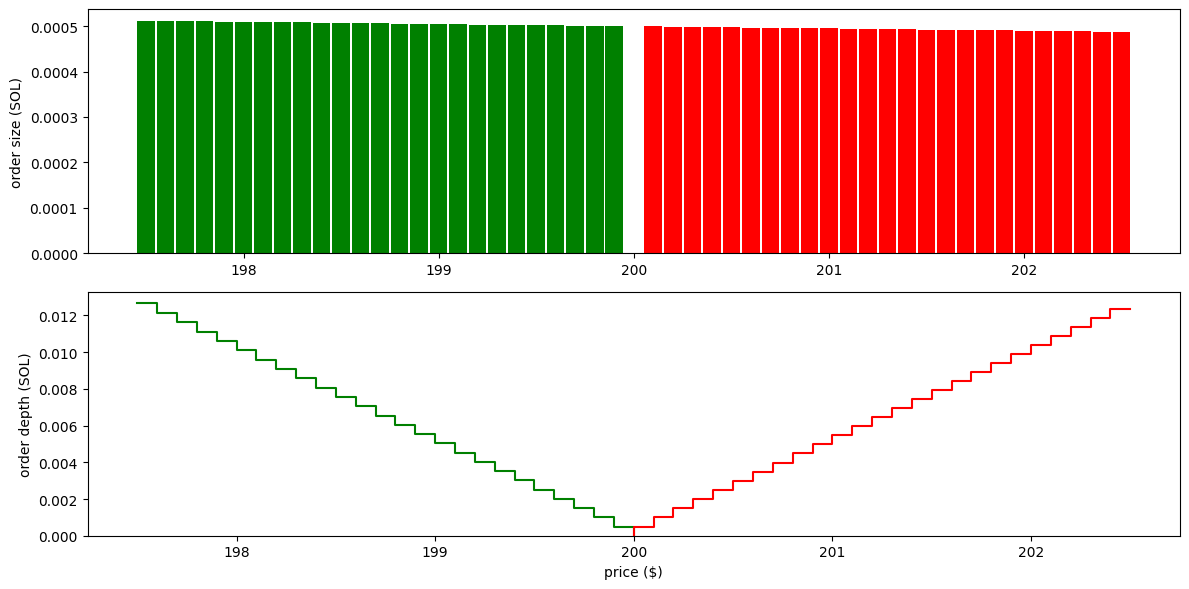

In [4]:
plot_result(compute_xyk_bids, compute_xyk_asks, 25, "1-xyk.png")

As the plot shows, at prices near $p_{\mathrm{pool}}$, liquidity is split roughly evenly across ticks. We prefer a different curve that concentrates liquidity around $p_{\mathrm{pool}}$.

## Solidly pool

$$
f(A, B) = A^3 \left( \frac{B}{R} \right) + A \left( \frac{B}{R} \right)^3 = K
$$

$$
\alpha = A \pm a
$$

$$
\beta = \frac{B \mp p a}{R}
$$

$$
g(a) = \alpha^3 \beta + \alpha \beta^3 - K
$$

$$
g'(a) = = \pm (-\frac{p}{R} \alpha^3 + a \alpha^2 \beta - \frac{3p}{R} \alpha \beta^2 + \beta^3)
$$

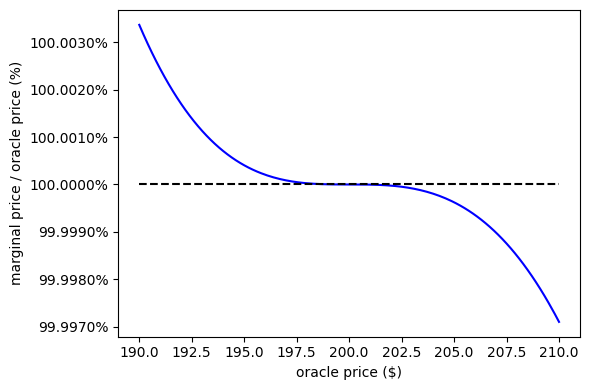

In [5]:
import matplotlib.ticker as mtick

# Reserve of the base asset (SOL)
A = 1
# Reserve of the quote asset (USD)
B = 200

def compute_p_m(R):
    return (3 * R * R * A * A * B + B * B * B) / (R * R * A * A * A + 3 * A * B * B)

def compute_p_m_over_R(R):
    return 100 * compute_p_m(R) / R

Rs = np.arange(190, 210.1, 0.1)
p_m_over_Rs = np.array(list(map(compute_p_m_over_R, Rs)))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(Rs, p_m_over_Rs, color="blue")
ax.plot(Rs, np.full(len(Rs), 100), color="black", linestyle="dashed")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("marginal price / oracle price (%)")
ax.set_xlabel("oracle price ($)")

plt.tight_layout()
plt.savefig("3-solidly-marginal-price-vs-oracle.png")
plt.show()

In [6]:
# Current oracle price
# Note: try changing this value to slightly above or below 200
R = 200

# Tick size
dp = 0.1

# Current marginal price
p_m = compute_p_m(R)

# The current invariant value
K = A * A * A * B / R + A * B * B * B / R / R / R

# Note: The math here is very unoptimized.
# Code here is for illustrative purpose, not for production,
# so we choose to stick close to the original math formulae.
def compute_solidly_bid_a(p, tolerance=1e-6, max_iterations=32):
    # Initial value is really important here.
    # A bad initial value can result in getting the trivial solution (zero).
    a_prev = A
    for _ in range(max_iterations):
        alpha = A + a_prev
        beta = (B - p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = - p * alpha * alpha * alpha / R + 3 * alpha * alpha * beta - 3 * p * alpha * beta * beta / R + beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")

def compute_solidly_bids(num_ticks):
    p = p_m - dp
    ps = [p_m]
    das = [0]
    cum_a = 0

    for _ in range(num_ticks):
        a = min(compute_solidly_bid_a(p), A)
        # If we go too much towards the left side, we may get the trivial solutoin (a = 0)
        if a <= 1e-6:
            break;
        da = a - cum_a
        ps.append(p)
        das.append(da)
        p -= dp
        cum_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

def compute_solidly_ask_a(p, tolerance=1e-6, max_iterations=32):
    a_prev = A
    for _ in range(max_iterations):
        alpha = A - a_prev
        beta = (B + p * a_prev) / R
        f = alpha * alpha * alpha * beta + alpha * beta * beta * beta - K
        f_prime = p * alpha * alpha * alpha / R - 3 * alpha * alpha * beta + 3 * p * alpha * beta * beta / R - beta * beta * beta
        a = a_prev - f / f_prime
        if abs(a - a_prev) <= tolerance:
            return a
        else:
            a_prev = a
    raise Exception("failed to converge within max iterations")

def compute_solidly_asks(num_ticks):
    p = p_m + dp
    ps = [p_m]
    das = [0]
    cum_a = 0
    remaining_b = B

    for _ in range(num_ticks):
        a = compute_solidly_ask_a(p)
        da = a - cum_a
        da = min(da, remaining_b / p)
        ps.append(p)
        das.append(da)
        p += dp
        remaining_b -= da * p
        cum_a = a

    return np.array(ps), np.array(das), np.cumsum(das)

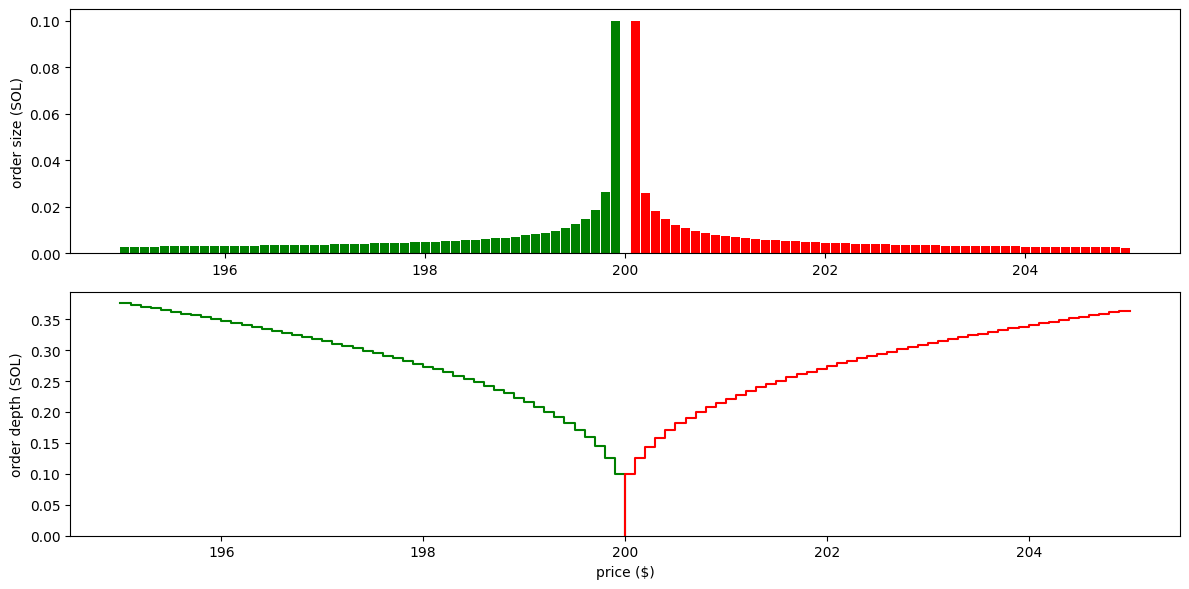

In [7]:
plot_result(compute_solidly_bids, compute_solidly_asks, 50, "2-solidly.png")

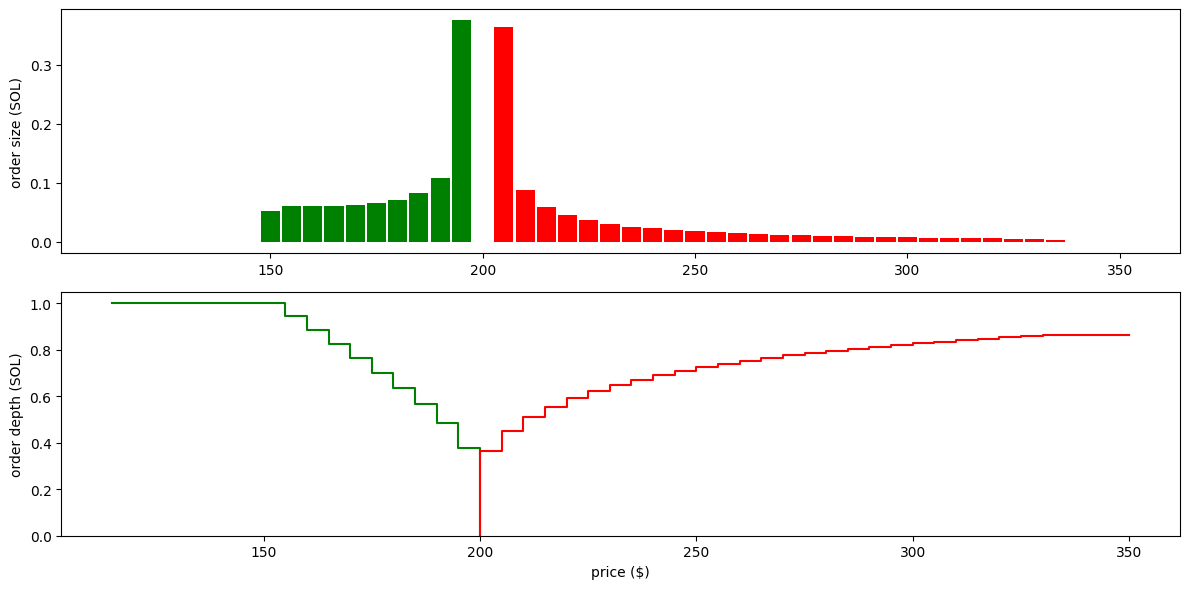

In [8]:
# Plot with a bigger tick size so that we can see the entire price range.
dp = 5
R = 200

plot_result(compute_solidly_bids, compute_solidly_asks)

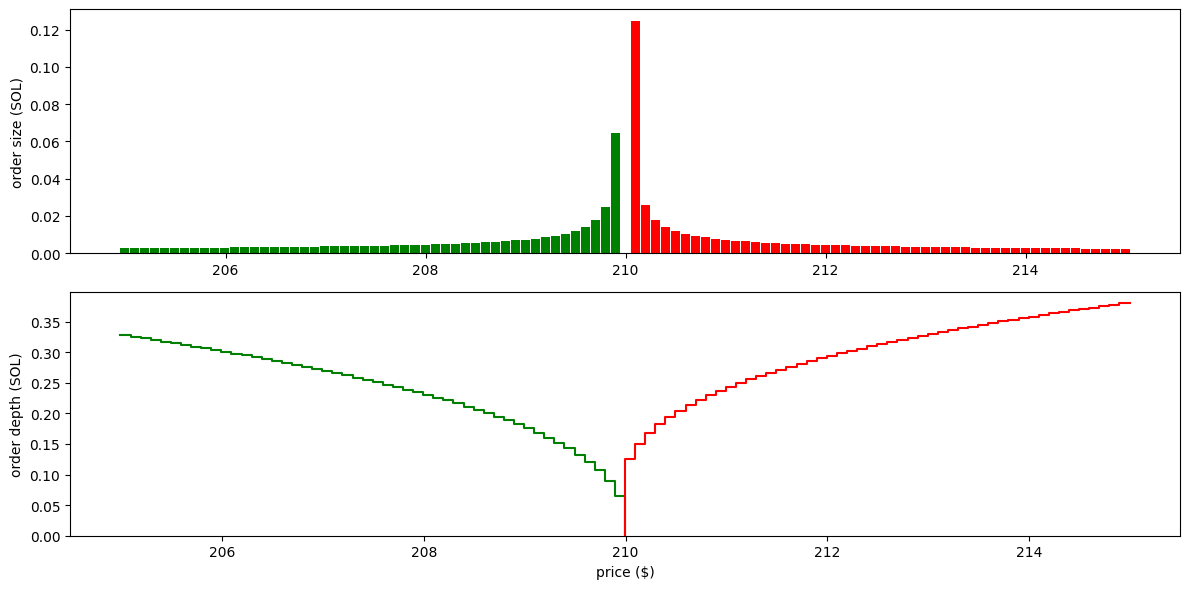

In [9]:
# What if the oracle price doesn't match exactly the pool's marginal price?
dp = 0.1
R = 210
p_m = compute_p_m(R)
K = A * A * A * B / R + A * B * B * B / R / R / R

plot_result(compute_solidly_bids, compute_solidly_asks, 50)